# Lesson 2: Cleaning and Merging

[Previous Lesson](01-Requirements-Data-Identification.ipynb) [Next Lesson](02-Clean-Merge.ipynb)

## Contents


## Getting Started


In [10]:
import linecache
import random

def get_line_count(input_file):
    """Count number of lines in a file"""
    count = 0
    with open(input_file) as infile:
        for line in infile:
            count += 1
    return count

def sample_file(input_file, output_file, fraction=0.1):
    """Exctract a subset of lines from a file"""
    total_line_count = get_line_count(input_file)
    sample_line_count = int(fraction * total_line_count)
    sample_line_numbers = random.sample(range(1, total_line_count), sample_line_count)
    sample_line_numbers.sort()
    sample_line_numbers.insert(0, 0)
    with open(output_file, 'w') as outfile:
        for line_number in sample_line_numbers:
            line = linecache.getline(input_file, line_number + 1)
            outfile.write(line)
                    
        

In [11]:
# want 
#home_columns = ["AppraisedLand", "AppraisedBuilding", "LastSalePrice", "Area", "Rooms", "Bedrooms", "Bathrooms", "AirConditioning", "Heat", "Fireplaces", "YearBuilt" ]
#home_data = pd.DataFrame(columns=home_columns)

In [12]:
# outdated
from IPython.display import IFrame
IFrame("./data/02-franklin-description.pdf", 800, 600)


In [13]:
from itertools import islice

with open("./data/02-franklin.csv") as infile:
    head = list(islice(infile, 5))

for line in head:
    print(line)

"PID","AEXMLND","AEXMBLD","AEXMTOT","APPRLND","APPRBLD","APPRTOT","AUDMAP","AUDRTG","LANDUSE","CAUV","SCHOOL","HOMSTD","MAILAD1","MAILAD2","MAILAD3","MAILAD4","TRANDT","TRANYR","NAME1","NAME2","NAME3","OWNER_ADD1","OWNER_ADD2","NBRHD","FLOOD","PCLASS","NOCARDS","ACREA","PRICE","ANN_TAX","STHNUM","STCONT","STHSFX","STDIRE","STNAME","STSFX","STADDR","USPS_CITY","STATE","ZIPCODE","DESCR1","DESCR2","DESCR3","TAXDESI","VALID","AREA_A","DWELTYP","ROOMS","BATHS","HBATHS","BEDRMS","AIRCOND","CINBRHD","COND","FIREPLC","GRADE","HEIGHT","NOSTORY","YEARBLT","PROPTYP","WALL","TIFMLND","TIFMBLD","POINT_X","POINT_Y"

"010-020705",0.00,0.00,0.00,8100.00,59600.00,67700.00,"D013",10.00,520,".00",2503,,"MIDWEST LOAN SERVICES",,"616 SHELDEN AVE STE 300","HOUGHTON MI 49931-1841",3/22/2016 0:00:00,2016,"NORRIS ROBIN R","HUGO ROBIN",,"246 ELDON AVE","COLUMBUS OH         43204",94.00,,"R","1",0.00,0.00,1455.02,"244","-","246","N","ELDON","AV","244 - 246 N ELDON AV","COLUMBUS","OH",43204,"244-6 ELDON AVE","HIL

In [14]:
import pandas as pd
franklin = pd.read_csv('./data/02-franklin.csv')

In [15]:
franklin.head()

,PID,AEXMLND,AEXMBLD,AEXMTOT,APPRLND,APPRBLD,APPRTOT,AUDMAP,AUDRTG,LANDUSE,...,GRADE,HEIGHT,NOSTORY,YEARBLT,PROPTYP,WALL,TIFMLND,TIFMBLD,POINT_X,POINT_Y
0,010-020705,0.0,0.0,0.0,8100.0,59600.0,67700.0,D013,10.0,520,...,C,DUPLEX,20.0,1925.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809670.02,714541.95
1,010-020716,0.0,0.0,0.0,4600.0,69800.0,74400.0,D021,11.0,510,...,C,OLD STYLE,20.0,1919.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809445.97,714129.83
2,010-020713,0.0,0.0,0.0,4900.0,60600.0,65500.0,D013,18.0,510,...,C,OLD STYLE,20.0,1925.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809641.41,714204.64
3,010-020784,0.0,0.0,0.0,5800.0,0.0,5800.0,D004,12.0,510,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1809302.85,715262.74
4,010-020773,0.0,0.0,0.0,5000.0,31200.0,36200.0,D004,8.0,510,...,C-1,RANCH,10.0,1922.0,NaN,WD/ALUM/VINYL,0.0,0.0,1808870.83,715286.02


In [16]:
franklin.columns.tolist()

['PID',
 'AEXMLND',
 'AEXMBLD',
 'AEXMTOT',
 'APPRLND',
 'APPRBLD',
 'APPRTOT',
 'AUDMAP',
 'AUDRTG',
 'LANDUSE',
 'CAUV',
 'SCHOOL',
 'HOMSTD',
 'MAILAD1',
 'MAILAD2',
 'MAILAD3',
 'MAILAD4',
 'TRANDT',
 'TRANYR',
 'NAME1',
 'NAME2',
 'NAME3',
 'OWNER_ADD1',
 'OWNER_ADD2',
 'NBRHD',
 'FLOOD',
 'PCLASS',
 'NOCARDS',
 'ACREA',
 'PRICE',
 'ANN_TAX',
 'STHNUM',
 'STCONT',
 'STHSFX',
 'STDIRE',
 'STNAME',
 'STSFX',
 'STADDR',
 'USPS_CITY',
 'STATE',
 'ZIPCODE',
 'DESCR1',
 'DESCR2',
 'DESCR3',
 'TAXDESI',
 'VALID',
 'AREA_A',
 'DWELTYP',
 'ROOMS',
 'BATHS',
 'HBATHS',
 'BEDRMS',
 'AIRCOND',
 'CINBRHD',
 'COND',
 'FIREPLC',
 'GRADE',
 'HEIGHT',
 'NOSTORY',
 'YEARBLT',
 'PROPTYP',
 'WALL',
 'TIFMLND',
 'TIFMBLD',
 'POINT_X',
 'POINT_Y']

In [17]:
# gathering data about homes
franklin.columns

Index(['PID', 'AEXMLND', 'AEXMBLD', 'AEXMTOT', 'APPRLND', 'APPRBLD', 'APPRTOT',
       'AUDMAP', 'AUDRTG', 'LANDUSE', 'CAUV', 'SCHOOL', 'HOMSTD', 'MAILAD1',
       'MAILAD2', 'MAILAD3', 'MAILAD4', 'TRANDT', 'TRANYR', 'NAME1', 'NAME2',
       'NAME3', 'OWNER_ADD1', 'OWNER_ADD2', 'NBRHD', 'FLOOD', 'PCLASS',
       'NOCARDS', 'ACREA', 'PRICE', 'ANN_TAX', 'STHNUM', 'STCONT', 'STHSFX',
       'STDIRE', 'STNAME', 'STSFX', 'STADDR', 'USPS_CITY', 'STATE', 'ZIPCODE',
       'DESCR1', 'DESCR2', 'DESCR3', 'TAXDESI', 'VALID', 'AREA_A', 'DWELTYP',
       'ROOMS', 'BATHS', 'HBATHS', 'BEDRMS', 'AIRCOND', 'CINBRHD', 'COND',
       'FIREPLC', 'GRADE', 'HEIGHT', 'NOSTORY', 'YEARBLT', 'PROPTYP', 'WALL',
       'TIFMLND', 'TIFMBLD', 'POINT_X', 'POINT_Y'],
      dtype='object')

In [18]:
# unique values
franklin.APPRTOT.unique()

array([  67700.,   74400.,   65500., ...,  896000., 1774500., 1760000.])

In [19]:
franklin.PCLASS.unique()

array(['R', 'C', 'E', 'I', nan, 'Z', 'A'], dtype=object)

In [20]:
franklin.PROPTYP.unique()

array([nan])

In [21]:
# home properties or fields we can use to filter out data
franklin_columns = ['APPRLND', 'APPRBLD', 'PCLASS', 'PRICE', 'AREA_A', 'ROOMS','BATHS', 
                    'HBATHS', 'BEDRMS', 'AIRCOND', 'FIREPLC','YEARBLT']

# copy vs view
franklin_subset = franklin[franklin_columns].copy()

In [22]:
franklin_subset.PCLASS.unique()

array(['R', 'C', 'E', 'I', nan, 'Z', 'A'], dtype=object)

In [23]:
print(franklin_subset[franklin_subset.PCLASS == 'R'].shape)
print(franklin_subset.shape)

(37902, 12)
(42974, 12)


In [24]:
franklin_subset = franklin_subset[franklin_subset.PCLASS == 'R']
franklin_subset.drop(['PCLASS'], axis=1, inplace=True)

In [25]:
franklin_subset.APPRBLD.describe()

count    3.790200e+04
mean     1.128262e+05
std      1.015612e+05
min      0.000000e+00
25%      5.130000e+04
50%      9.340000e+04
75%      1.461000e+05
max      2.700000e+06
Name: APPRBLD, dtype: float64

In [26]:
print(len(franklin_subset[franklin_subset.APPRBLD <= 0]))
print(len(franklin_subset))

2858
37902


In [27]:
franklin_subset = franklin_subset[franklin_subset.APPRBLD > 0]

In [28]:
franklin_subset[['BATHS', 'HBATHS']].dtypes

BATHS     int64
HBATHS    int64
dtype: object

In [29]:
franklin_subset["Bathrooms"] = franklin_subset.BATHS.fillna(0) + 0.5 * franklin_subset.HBATHS.fillna(0)

In [30]:
franklin_subset.Bathrooms.unique()

array([2. , 1.5, 1. , 3. , 2.5, 4. , 3.5, 0. , 5. , 4.5, 7. , 0.5, 6. ,
       6.5, 5.5, 7.5])

In [31]:
franklin_subset.drop(['BATHS', "HBATHS"], axis=1, inplace=True)

In [32]:
# process aircond
franklin_subset.AIRCOND.unique()

array([1, 0])

In [33]:
franklin.AIRCOND.unique()

array([1, 0])

In [34]:
pd.set_option('display.max_column', 100)
franklin.head()

,PID,AEXMLND,AEXMBLD,AEXMTOT,APPRLND,APPRBLD,APPRTOT,AUDMAP,AUDRTG,LANDUSE,CAUV,SCHOOL,HOMSTD,MAILAD1,MAILAD2,MAILAD3,MAILAD4,TRANDT,TRANYR,NAME1,NAME2,NAME3,OWNER_ADD1,OWNER_ADD2,NBRHD,FLOOD,PCLASS,NOCARDS,ACREA,PRICE,ANN_TAX,STHNUM,STCONT,STHSFX,STDIRE,STNAME,STSFX,STADDR,USPS_CITY,STATE,ZIPCODE,DESCR1,DESCR2,DESCR3,TAXDESI,VALID,AREA_A,DWELTYP,ROOMS,BATHS,HBATHS,BEDRMS,AIRCOND,CINBRHD,COND,FIREPLC,GRADE,HEIGHT,NOSTORY,YEARBLT,PROPTYP,WALL,TIFMLND,TIFMBLD,POINT_X,POINT_Y
0,010-020705,0.0,0.0,0.0,8100.0,59600.0,67700.0,D013,10.0,520,0.0,2503,NaN,MIDWEST LOAN SERVICES,NaN,616 SHELDEN AVE STE 300,HOUGHTON MI 49931-1841,3/22/2016 0:00:00,2016.0,NORRIS ROBIN R,HUGO ROBIN,NaN,246 ELDON AVE,COLUMBUS OH 43204,94.0,NaN,R,1.0,0.0,0.0,1455.02,244.0,-,246.0,N,ELDON,AV,244 - 246 N ELDON AV,COLUMBUS,OH,43204.0,244-6 ELDON AVE,HILL CREST PARK,LOT 24,CITY OF COLUMBUS,N,2264,1.0,10,2,0,4,1,NaN,NaN,NaN,C,DUPLEX,20.0,1925.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809670.02,714541.95
1,010-020716,0.0,0.0,0.0,4600.0,69800.0,74400.0,D021,11.0,510,0.0,2503,NaN,TINA L CALDWELL,JAMES P KLAUSMAN,189 ELDON AVE,COLUMBUS OH 43204-3706,4/16/1996 0:00:00,1996.0,CALDWELL TINA L,JAMES P KLAUSMAN,NaN,NaN,NaN,94.0,NaN,R,1.0,0.0,50000.0,1578.72,189.0,NaN,NaN,N,ELDON,AV,189 N ELDON AV,COLUMBUS,OH,43204.0,189 N ELDEN AVE,HILL CREST PARK,LOT 39,CITY OF COLUMBUS,Y,1835,1.0,7,1,1,4,1,NaN,NaN,1.0,C,OLD STYLE,20.0,1919.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809445.97,714129.83
2,010-020713,0.0,0.0,0.0,4900.0,60600.0,65500.0,D013,18.0,510,0.0,2503,NaN,WELLS FARGO REAL ESTATE,MAC X2302-04D,1 HOME CAMPUS,DES MOINES IA 50328-0001,3/13/2015 0:00:00,2015.0,CROYLE STEVE V,NaN,NaN,202 ELDON AVE,COLUMBUS OH 43204,94.0,NaN,R,1.0,0.0,64000.0,1390.16,202.0,NaN,NaN,N,ELDON,AV,202 N ELDON AV,COLUMBUS,OH,43204.0,202 ELDON AVE,HILLCREST PK,LOT 32,CITY OF COLUMBUS,Y,1656,1.0,7,1,0,3,1,NaN,NaN,NaN,C,OLD STYLE,20.0,1925.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809641.41,714204.64
3,010-020784,0.0,0.0,0.0,5800.0,0.0,5800.0,D004,12.0,510,0.0,2503,NaN,HUNTINGTON MORTGAGE CORP,NaN,PO BOX 182661,COLUMBUS OH 43218-2661,9/18/2006 0:00:00,2006.0,TERRY DAVID G,TERRY CONSTANCE E,NaN,2450 WESTWOOD DR,COLUMBUS OH 43204,94.0,NaN,R,NaN,0.0,134000.0,126.20,NaN,NaN,NaN,NaN,WESTWOOD,DR,WESTWOOD DR,COLUMBUS,OH,43204.0,N S WESTWOOD DR,HILLCREST PARK,LOT 124,CITY OF COLUMBUS,Y,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1809302.85,715262.74
4,010-020773,0.0,0.0,0.0,5000.0,31200.0,36200.0,D004,8.0,510,0.0,2503,NaN,CHRISTOPHER M SNAPP,NaN,6448 SHARON WOODS BLVD,COLUMBUS OH 43229-2072,10/21/2011 0:00:00,2011.0,SNAPP CHRISTOPHER M,NaN,NaN,351 ELDON AVE,COLUMBUS OH 43204,94.0,NaN,R,1.0,0.0,0.0,768.12,351.0,NaN,NaN,NaN,ELDON,AV,351 ELDON AV,COLUMBUS,OH,43204.0,351 ELDEN AVE,HILLCREST PARK,LOT 113,CITY OF COLUMBUS,N,1000,1.0,5,1,0,2,1,NaN,NaN,NaN,C-1,RANCH,10.0,1922.0,NaN,WD/ALUM/VINYL,0.0,0.0,1808870.83,715286.02


In [35]:
franklin_subset.AIRCOND = franklin_subset.AIRCOND.astype('bool')

In [36]:
franklin_subset.FIREPLC.unique()

array([nan,  1.,  4.,  2.,  3.,  0.,  5.,  6.,  7.])

In [37]:
franklin_subset.FIREPLC.fillna(value=0, inplace=True)

In [38]:
franklin_subset.columns

Index(['APPRLND', 'APPRBLD', 'PRICE', 'AREA_A', 'ROOMS', 'BEDRMS', 'AIRCOND',
       'FIREPLC', 'YEARBLT', 'Bathrooms'],
      dtype='object')

In [39]:
franklin_subset.dtypes

APPRLND      float64
APPRBLD      float64
PRICE        float64
AREA_A         int64
ROOMS          int64
BEDRMS         int64
AIRCOND         bool
FIREPLC      float64
YEARBLT      float64
Bathrooms    float64
dtype: object

In [40]:
#home_columns = ["AppraisedLand", "AppraisedBuilding", "LastSalePrice", "Area", "Rooms", "Bedrooms", "Bathrooms", "AirConditioning", "Heat", "Fireplaces", "YearBuilt" ]
#home_data = pd.DataFrame(columns=home_columns)

In [41]:
home_data = franklin_subset.copy()

In [42]:
home_data.rename(
    {'APPRLND': 'AppraisedLand',
     'APPRBLD': 'AppraisedBuilding',
     'PRICE': 'SalePrice',
     'AREA_A': 'Area', 
     'ROOMS':'Rooms',
     'BEDRMS':'Bedrooms',
     'AIRCOND': 'AirConditioning', 
     'FIREPLC': 'Fireplaces', 
     'YEARBLT': 'YearBuilt'
    },
    axis=1 ,
    inplace=True
)

In [43]:
home_data.columns

Index(['AppraisedLand', 'AppraisedBuilding', 'SalePrice', 'Area', 'Rooms',
       'Bedrooms', 'AirConditioning', 'Fireplaces', 'YearBuilt', 'Bathrooms'],
      dtype='object')

In [44]:
home_data['Heat'] = True
home_data['County'] = "Franklin"

In [45]:
home_data.head()

,AppraisedLand,AppraisedBuilding,SalePrice,Area,Rooms,Bedrooms,AirConditioning,Fireplaces,YearBuilt,Bathrooms,Heat,County
0,8100.0,59600.0,0.0,2264,10,4,True,0.0,1925.0,2.0,True,Franklin
1,4600.0,69800.0,50000.0,1835,7,4,True,1.0,1919.0,1.5,True,Franklin
2,4900.0,60600.0,64000.0,1656,7,3,True,0.0,1925.0,1.0,True,Franklin
4,5000.0,31200.0,0.0,1000,5,2,True,0.0,1922.0,1.0,True,Franklin
5,4600.0,63300.0,0.0,1306,6,4,True,0.0,1948.0,2.0,True,Franklin


In [46]:
### Licking County

In [47]:
from itertools import islice

with open("./data/02-licking.txt") as infile:
    head = list(islice(infile, 5))

for line in head:
    print(line)

fldParcelID;fldParcelNo;fldRoutingNo;fldOwner;fldCardNo;fldMaxCards;fldRecheck;fldSchoolDistrict;fldTaxDistrict;fldLegalDesc;fldLocationAddress;fldNeighborhood;fldPropertyType;fldLUC;fldTopo;fldAccess;fldUtilities;fldNotes;fldNotes2;fldMarketLand;fldMarketImprov;fldMarketTotal;fldCAUVLand;fldCAUVImprov;fldCAUVTotal;fldSketchPath;fldStyle;fldStories;fldExterior;fldHeating;fldCooling;fldBasement;fldFullBaths;fldHalfBaths;fldOtherBaths;fldAttic;fldAtticHeating;fldRooms;fldBedrooms;fldFamilyRooms;fldDiningRooms;fldLivingRooms;fldFinishedLivingArea;fldFinishedBasementArea;fldYearBuilt;fldEffYearBuilt;fldYearRemodeled;fldCondition;fldGrade;fldBasementGarage;fldFireplaceOpenings;fldFireplaceStacks;fldFirstFloorArea;fldFirstFloorCost;fldUpperFloorArea;fldUpperFloorCost;fldAtticArea;fldAtticCost;fldHalfFloorArea;fldHalfFloorCost;fldFinishedBasementCost;fldUnfinishedLivingArea;fldUnfinishedLivingCost;fldCrawlArea;fldCrawlCost;fldBasementArea;fldBasementCost;fldBasementGarageArea;fldBasementGarag

In [48]:
licking = pd.read_csv("./data/02-licking.txt")

ParserError: Error tokenizing data. C error: Expected 33 fields in line 3, saw 34


In [49]:
licking = pd.read_csv("./data/02-licking.txt", delimiter=";")

ParserError: Error tokenizing data. C error: Expected 181 fields in line 1608, saw 182


In [50]:
typical_line = linecache.getline("./data/02-licking.txt", 2)
error_line = linecache.getline("./data/02-licking.txt", 1608)

In [51]:
print(typical_line)
print(error_line)

35;001-000066-00.009;001-006.00-120.000;HARDY RONALD J & LINDA B;1;1;No;NORTHRIDGE LSD;001 - BENNINGTON T-NRDGE LSD;LOT 10 PT   3.68 AC;8713 BENNER RD;06700 Bennington-T;Dwelling;511 Single family unplatted 0-09.9;;;2578 Electric Gas Well Septic;;;50300;138100;188400;0;0;0;C:\tempPRCsketch.bmp;Single Family;1;Frame;Central Warm Air;Central;Full Basement;2.0;;;None;;6.0;3.0;;0.0;;1,790;0;2002;2002;;Average;90;;;;1,790;115,400;0;0;0;0;0;0;0;0;0;0;0;1,790;30,600;0;0;;0;;0;;5,400;;4,500;S(0), O(0);0;1;1;;15,400;;0;171,300;90;-17,130;100;0;;;166,200;-33,240;No;20;0;0.00000;;133,000;5,100;138,100;Well/Septic;12,000;2016;2015;2014;41,300;41,300;41,300;141,500;141,500;141,500;182,800;182,800;182,800;06/07/2001;11/01/2000;07/06/1999;;1;4;4;;FD - FIDUCIARY;EX - EXEMPT CONVEYANCE;EX - EXEMPT CONVEYANCE;;32000.00;0.00;0.00;;01721     ;99999     ;99999     ;;Y;N;N;;Y;Y;Y;;BEVIER MARLENE M TRUSTEE;SHARROCK LORI S TRUSTEE;Refer to deed;;;50,300;5,100;15,400;2017;146,000;No;No;No;No;No;0;100;138,100;0

In [52]:
print(typical_line.count(";"))
print(error_line.count(";"))

180
181


In [53]:
from itertools import zip_longest

header_line = linecache.getline("./data/02-licking.txt", 1)

header_entries = header_line.split(";")
typical_entries = typical_line.split(";")
error_entries = error_line.split(";")

for entry in zip_longest(header_entries, typical_entries, error_entries):
    print(entry)

('fldParcelID', '35', '14934')
('fldParcelNo', '001-000066-00.009', '020-051654-00.000')
('fldRoutingNo', '001-006.00-120.000', '020-116.18-017.000')
('fldOwner', 'HARDY RONALD J & LINDA B', 'FULLER JEAN A TRUSTEE')
('fldCardNo', '1', '1')
('fldMaxCards', '1', '1')
('fldRecheck', 'No', 'No')
('fldSchoolDistrict', 'NORTHRIDGE LSD', 'GRANVILLE EVSD')
('fldTaxDistrict', '001 - BENNINGTON T-NRDGE LSD', '020 - GRANVILLE T - GRANVILLE V&EVSD')
('fldLegalDesc', 'LOT 10 PT   3.68 AC', 'LOT 116')
('fldLocationAddress', '8713 BENNER RD', '128 E BROADWAY')
('fldNeighborhood', '06700 Bennington-T', '05500 Granville-Vil-West Half')
('fldPropertyType', 'Dwelling', 'Building')
('fldLUC', '511 Single family unplatted 0-09.9', '430 Resturant')
('fldTopo', '', ' cafteria and/or bar')
('fldAccess', '', '')
('fldUtilities', '2578 Electric Gas Well Septic', '')
('fldNotes', '', '6 All')
('fldNotes2', '', '')
('fldMarketLand', '50300', '')
('fldMarketImprov', '138100', '165100')
('fldMarketTotal', '188400',

In [54]:
licking = pd.read_csv("./data/02-licking.txt", delimiter="(?<!Resturant);", engine="python")

In [55]:
licking.shape

(8363, 181)

```python
# problem is "fldLUC: 430 Resturant; cafteria and/or bar"
# could use error_bad_lines with read_csv
# could use regex separator

# difference in dtypes due to 0 as float vs int and NaN
import io

class StringIOWithReplace(io.FileIO):
    def __init__(self, path, old_value, new_value):
        super(StringIOWithReplace, self).__init__(path)
        self._old_value = old_value.encode()
        self._new_value = new_value.encode()
    
    def read(self, *args, **kwargs):
        return super(StringIOWithReplace, self).read(*args, **kwargs).replace(self._old_value, self._new_value)
        

            
licking_file = StringIOWithReplace("./data/02-licking.txt", "Resturant; cafteria", "Resturant cafteria")
licking = pd.read_csv(licking_file, delimiter=";")
```    



In [56]:
licking.columns.tolist()

['fldParcelID',
 'fldParcelNo',
 'fldRoutingNo',
 'fldOwner',
 'fldCardNo',
 'fldMaxCards',
 'fldRecheck',
 'fldSchoolDistrict',
 'fldTaxDistrict',
 'fldLegalDesc',
 'fldLocationAddress',
 'fldNeighborhood',
 'fldPropertyType',
 'fldLUC',
 'fldTopo',
 'fldAccess',
 'fldUtilities',
 'fldNotes',
 'fldNotes2',
 'fldMarketLand',
 'fldMarketImprov',
 'fldMarketTotal',
 'fldCAUVLand',
 'fldCAUVImprov',
 'fldCAUVTotal',
 'fldSketchPath',
 'fldStyle',
 'fldStories',
 'fldExterior',
 'fldHeating',
 'fldCooling',
 'fldBasement',
 'fldFullBaths',
 'fldHalfBaths',
 'fldOtherBaths',
 'fldAttic',
 'fldAtticHeating',
 'fldRooms',
 'fldBedrooms',
 'fldFamilyRooms',
 'fldDiningRooms',
 'fldLivingRooms',
 'fldFinishedLivingArea',
 'fldFinishedBasementArea',
 'fldYearBuilt',
 'fldEffYearBuilt',
 'fldYearRemodeled',
 'fldCondition',
 'fldGrade',
 'fldBasementGarage',
 'fldFireplaceOpenings',
 'fldFireplaceStacks',
 'fldFirstFloorArea',
 'fldFirstFloorCost',
 'fldUpperFloorArea',
 'fldUpperFloorCost',
 'fl

In [57]:
pd.set_option('display.max_column', 200)
licking.head()

,fldParcelID,fldParcelNo,fldRoutingNo,fldOwner,fldCardNo,fldMaxCards,fldRecheck,fldSchoolDistrict,fldTaxDistrict,fldLegalDesc,fldLocationAddress,fldNeighborhood,fldPropertyType,fldLUC,fldTopo,fldAccess,fldUtilities,fldNotes,fldNotes2,fldMarketLand,fldMarketImprov,fldMarketTotal,fldCAUVLand,fldCAUVImprov,fldCAUVTotal,fldSketchPath,fldStyle,fldStories,fldExterior,fldHeating,fldCooling,fldBasement,fldFullBaths,fldHalfBaths,fldOtherBaths,fldAttic,fldAtticHeating,fldRooms,fldBedrooms,fldFamilyRooms,fldDiningRooms,fldLivingRooms,fldFinishedLivingArea,fldFinishedBasementArea,fldYearBuilt,fldEffYearBuilt,fldYearRemodeled,fldCondition,fldGrade,fldBasementGarage,fldFireplaceOpenings,fldFireplaceStacks,fldFirstFloorArea,fldFirstFloorCost,fldUpperFloorArea,fldUpperFloorCost,fldAtticArea,fldAtticCost,fldHalfFloorArea,fldHalfFloorCost,fldFinishedBasementCost,fldUnfinishedLivingArea,fldUnfinishedLivingCost,fldCrawlArea,fldCrawlCost,fldBasementArea,fldBasementCost,fldBasementGarageArea,fldBasementGarageCost,fldExtWallArea,fldExtWallCost,fldHeatingArea,fldHeatingCost,fldCoolingArea,fldCoolingCost,fldPlumbingArea,fldPlumbingCost,fldFireplaceArea,fldFireplaceCost,fldIdenticalMultiplierCount,fldIdenticalMultiplierCost,fldEnhancementArea,fldEnhancementCost,fldFeaturesArea,fldFeaturesCost,fldSubTotalBeforeGrade,fldGradeArea,fldGradeCost,fldCostFactorArea,fldCostFactorCost,fldUngradedFeaturesArea,fldUngradedFeaturesCost,fldRCN,fldDepreciation,fldDepreciationOverride,fldDepreciationArea,fldObsolesence,fldObsolesenceArea,fldImprovements,fldRCNLD,fldImprovementsTotal,fldFVC,fldWellSeptic,fldWellSepticValue,fldValueHistoryYear1,fldValueHistoryYear2,fldValueHistoryYear3,fldValueHistoryLand1,fldValueHistoryLand2,fldValueHistoryLand3,fldValueHistoryImprov1,fldValueHistoryImprov2,fldValueHistoryImprov3,fldValueHistoryTotal1,fldValueHistoryTotal2,fldValueHistoryTotal3,fldSalesDate1,fldSalesDate2,fldSalesDate3,fldSalesDate4,fldSalesNoParcels1,fldSalesNoParcels2,fldSalesNoParcels3,fldSalesNoParcels4,fldSalesType1,fldSalesType2,fldSalesType3,fldSalesType4,fldSalesPrice1,fldSalesPrice2,fldSalesPrice3,fldSalesPrice4,fldSalesConveyance1,fldSalesConveyance2,fldSalesConveyance3,fldSalesConveyance4,fldSalesValid1,fldSalesValid2,fldSalesValid3,fldSalesValid4,fldSalesLandOnly1,fldSalesLandOnly2,fldSalesLandOnly3,fldSalesLandOnly4,fldSalesPrevOwner1,fldSalesPrevOwner2,fldSalesPrevOwner3,fldSalesPrevOwner4,fldFeatureTotal,fldLandTotal,fldImprovTotal,fldEnhancementTotal,fldTaxYear,fldSubtotal,fldAdditionalInspections,fldAdditionalEnhancements,fldAdditionalFeatures,fldAdditionalLand,fldAdditionalImprovements,fldNeighAdj,fldNeighAdjArea,fldCard1Total,fldCard2Total,fldCard3Total,fldCard4Total,fldCard5Total,fldParcelTotal,fldPicPath,fldAcreageTotal,fldSortOrder,fldCropTotal,fldWoodsTotal,fldNotFarmedTotal,fldConservationTotal,fldNeighAdjLandOverride,fldNeighAdjAreaLand,fldMailingAddress1,fldMailingAddress2,fldMailingAddress3,fldMailingAddress4,fldMailingAddress5
0,35,001-000066-00.009,001-006.00-120.000,HARDY RONALD J & LINDA B,1,1,No,NORTHRIDGE LSD,001 - BENNINGTON T-NRDGE LSD,LOT 10 PT 3.68 AC,8713 BENNER RD,06700 Bennington-T,Dwelling,511 Single family unplatted 0-09.9,NaN,NaN,2578 Electric Gas Well Septic,NaN,NaN,50300.0,138100.0,188400.0,0.0,0.0,0.0,C:\tempPRCsketch.bmp,Single Family,1,Frame,Central Warm Air,Central,Full Basement,2.0,NaN,NaN,None,NaN,6.0,3.0,NaN,0.0,NaN,"1,790",0.0,2002.0,2002.0,NaN,Average,90.0,NaN,NaN,NaN,"1,790","115,400",0,0,0,0,0,0,0,0,0.0,0,0,"1,790","30,600",0.0,0,NaN,0,NaN,0,NaN,"5,400",NaN,"4,500","S(0), O(0)",0,1.0,1.0,NaN,"15,400",NaN,0,"171,300",90.0,"-17,130",100.0,0,NaN,NaN,"166,200","-33,240",No,20.0,0.0,0.0,NaN,"133,000","5,100","138,100",Well/Septic,"12,000",2016.0,2015.0,2014.0,"41,300","41,300","41,300","141,500","141,500","141,500","182,800","182,800","182,800",06/07/2001,11/01/2000,07/06/1999,NaN,1.0,4.0,4.0,NaN,FD - FIDUCIARY,EX - EXEMPT CONVEYANCE,EX - EXEMPT CONVEYANCE,NaN,32000.0,0.0,0.0,NaN,01721,99999,99999,NaN,Y,N,N,NaN,Y,Y,Y,

In [58]:
licking.fldPropertyType.unique()

array(['Dwelling', 'Other', nan, 'Building'], dtype=object)

In [59]:
[column for column in licking.columns if "sales" in column.lower()]

['fldSalesDate1',
 'fldSalesDate2',
 'fldSalesDate3',
 'fldSalesDate4',
 'fldSalesNoParcels1',
 'fldSalesNoParcels2',
 'fldSalesNoParcels3',
 'fldSalesNoParcels4',
 'fldSalesType1',
 'fldSalesType2',
 'fldSalesType3',
 'fldSalesType4',
 'fldSalesPrice1',
 'fldSalesPrice2',
 'fldSalesPrice3',
 'fldSalesPrice4',
 'fldSalesConveyance1',
 'fldSalesConveyance2',
 'fldSalesConveyance3',
 'fldSalesConveyance4',
 'fldSalesValid1',
 'fldSalesValid2',
 'fldSalesValid3',
 'fldSalesValid4',
 'fldSalesLandOnly1',
 'fldSalesLandOnly2',
 'fldSalesLandOnly3',
 'fldSalesLandOnly4',
 'fldSalesPrevOwner1',
 'fldSalesPrevOwner2',
 'fldSalesPrevOwner3',
 'fldSalesPrevOwner4']

In [60]:
[column for column in licking.columns if "area" in column.lower()]

['fldFinishedLivingArea',
 'fldFinishedBasementArea',
 'fldFirstFloorArea',
 'fldUpperFloorArea',
 'fldAtticArea',
 'fldHalfFloorArea',
 'fldUnfinishedLivingArea',
 'fldCrawlArea',
 'fldBasementArea',
 'fldBasementGarageArea',
 'fldExtWallArea',
 'fldHeatingArea',
 'fldCoolingArea',
 'fldPlumbingArea',
 'fldFireplaceArea',
 'fldEnhancementArea',
 'fldFeaturesArea',
 'fldGradeArea',
 'fldCostFactorArea',
 'fldUngradedFeaturesArea',
 'fldDepreciationArea',
 'fldObsolesenceArea',
 'fldNeighAdjArea',
 'fldNeighAdjAreaLand']

In [61]:
[column for column in licking.columns if "bath" in column.lower()]

['fldFullBaths', 'fldHalfBaths', 'fldOtherBaths']

In [62]:
#home_columns = ["AppraisedLand", "AppraisedBuilding", "LastSalePrice", "Area", "Rooms", "Bedrooms", "Bathrooms", "AirConditioning", "Heat", "Fireplaces", "YearBuilt" ]
licking_columns = ["fldMarketLand", "fldMarketImprov", "fldSalesPrice1", "fldSalesPrice2", "fldSalesPrice3", "fldSalesPrice4", "fldFinishedLivingArea", "fldRooms", "fldBedrooms", "fldFullBaths", "fldHalfBaths", "fldOtherBaths",  "fldHeating", "fldCooling", "fldFireplaceOpenings", "fldYearBuilt"]
licking_subset = licking[licking.fldPropertyType == "Dwelling"][licking_columns].copy()

In [63]:
licking_subset.shape

(5859, 16)

In [64]:
# vectorize vs row-by-row
licking_subset['LastSalePrice'] = licking_subset[['fldSalesPrice1', 'fldSalesPrice2', 'fldSalesPrice3', 'fldSalesPrice4']].max(axis=1)

In [65]:
licking_subset.drop(['fldSalesPrice1', 'fldSalesPrice2', 'fldSalesPrice3', 'fldSalesPrice4'], axis=1, inplace=True)

In [66]:
licking_subset['Bathrooms'] = licking_subset.fldFullBaths.fillna(0) + 0.5 * licking_subset.fldHalfBaths.fillna(0) + 0.25 * licking_subset.fldOtherBaths.fillna(0)

In [67]:
licking_subset.drop(["fldFullBaths", "fldHalfBaths", "fldOtherBaths"], axis=1, inplace=True)

In [68]:
licking_subset.fldHeating.unique()

array(['Central Warm Air', 'Heat Pump', 'No Heat', 'Geothermal',
       'Electric baseboard', nan, 'Hot Water or Steam'], dtype=object)

In [69]:
def hasHeat(value):
    heat_values = ["Central Warm Air", "Heat Pump", "Geothermal", "Electric baseboard", "Hot Water or Steam"]
    return value in heat_values

licking_subset.fldHeating = licking_subset.fldHeating.apply(hasHeat)

In [70]:
licking_subset.fldCooling.unique()

array(['Central', 'None', nan], dtype=object)

In [71]:
licking_subset.fldCooling = licking_subset.fldCooling == "Central"

In [72]:
licking_subset.fldFireplaceOpenings.fillna(0, inplace=True)

In [73]:
licking_subset['County'] = "Licking"

In [74]:
licking_subset.head()

,fldMarketLand,fldMarketImprov,fldFinishedLivingArea,fldRooms,fldBedrooms,fldHeating,fldCooling,fldFireplaceOpenings,fldYearBuilt,LastSalePrice,Bathrooms,County
0,50300.0,138100.0,"1,790",6.0,3.0,True,True,0.0,2002.0,32000.0,2.0,Licking
1,86300.0,162700.0,"2,326",7.0,4.0,True,True,0.0,1998.0,0.0,3.0,Licking
2,53100.0,24500.0,"1,400",5.0,3.0,True,False,0.0,1991.0,117000.0,2.0,Licking
3,32100.0,169900.0,"1,802",5.0,3.0,True,True,1.0,2003.0,210000.0,2.0,Licking
5,24200.0,111200.0,960,5.0,3.0,True,True,0.0,1989.0,144900.0,1.0,Licking


In [75]:
licking_subset.rename(
    {'fldMarketLand': 'AppraisedLand',
     'fldMarketImprov': 'AppraisedBuilding',
     'LastSalePrice': 'SalePrice',
     'fldFinishedLivingArea': 'Area', 
     'fldRooms':'Rooms',
     'fldBedrooms':'Bedrooms',
     'fldHeating': "Heat",
     'fldCooling': 'AirConditioning', 
     'fldFireplaceOpenings': 'Fireplaces', 
     'fldYearBuilt': 'YearBuilt'
    },
    axis=1 ,
    inplace=True
)

In [76]:
licking_subset.head()

,AppraisedLand,AppraisedBuilding,Area,Rooms,Bedrooms,Heat,AirConditioning,Fireplaces,YearBuilt,SalePrice,Bathrooms,County
0,50300.0,138100.0,"1,790",6.0,3.0,True,True,0.0,2002.0,32000.0,2.0,Licking
1,86300.0,162700.0,"2,326",7.0,4.0,True,True,0.0,1998.0,0.0,3.0,Licking
2,53100.0,24500.0,"1,400",5.0,3.0,True,False,0.0,1991.0,117000.0,2.0,Licking
3,32100.0,169900.0,"1,802",5.0,3.0,True,True,1.0,2003.0,210000.0,2.0,Licking
5,24200.0,111200.0,960,5.0,3.0,True,True,0.0,1989.0,144900.0,1.0,Licking


In [77]:
home_data.shape

(35044, 12)

In [78]:
licking_subset.shape

(5859, 12)

In [79]:
all([x in licking_subset.columns for x in home_data.columns])

True

In [80]:
df = pd.DataFrame([[1, 2], [3, 4]], columns=list('AB'))
d2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('BA'))

In [81]:
df

,A,B
0,1,2
1,3,4


In [82]:
d2

,B,A
0,5,6
1,7,8


In [83]:
df.append(d2, ignore_index=True, )

,A,B
0,1,2
1,3,4
2,6,5
3,8,7


In [84]:
home_data = home_data.append(licking_subset, ignore_index=True)

In [85]:
home_data.shape

(40903, 12)

In [86]:
home_data.County.unique()

array(['Franklin', 'Licking'], dtype=object)

In [87]:
### Fairfield

In [88]:
!pip3 install geopandas

In [89]:
import geopandas

In [90]:
#https://www.co.fairfield.oh.us/gis/
fairfield = geopandas.read_file("zip://data/02-fairfield-gis.zip")

In [91]:
fairfield.head()

,PIN,Shape_Leng,Shape_Area,PARID,OWN1,OWN2,LASTNAME,ADRNO,ADRDIR,ADRSTR,ADRSUF,ADRSUF2,PADDR1,MADDR1,MADDR2,MADDR3,MCITYNAME,MSTATECODE,MZIP1,LEGAL1,LEGAL2,LEGAL3,ACRES,MAPNUM,ROUTENUM,LUC,PARTIAL_,NBHD,STORIES,EXTWALL,STYLE,SFLA,YRBLT,YRREMOD,RMTOT,RMBED,RMFAM,FIXBATH,FIXHALF,FIXTOT,BSMT,HEAT,FUEL,ATTIC,WBFP_O,WBFP_S,WBFP_PF,BSMTCAR,FINBSMTARE,RECROMAREA,MASTRIMARE,BOOK,PAGE,SALEDT,TRANSDT,RECORDDT,PRICE,SALEVAL,SALETYPE,APRLAND,APRBLDG,FARMLAND,AGAPPL,SALEYEAR,APPRVAL,SALESRATIO,GRDFACT,CDU,CLASS,DEPR,geometry
0,0010000100,7168.370932,1.061245e+06,0010000100,PONTIUS GREGORY L,,PONTIUS,980.0,,ROCK MILL,RD,SW,980 ROCK MILL RD SW,980 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,24.20,100,01300,111,,00053.000,2.0,8,5,1770,1900,0,4,2,0,1,0,5,3,3,4,1,0,0,0,0,0,0,0,,,None,None,None,0.0,,,138220.0,101810.0,59020.0,1,0,240030.0,0.00,0.85,VG,A,65,"POLYGON ((1905593.568425 624820.4415500164, 19..."
1,0010000200,2051.863544,2.177793e+05,0010000200,CRUM WILLIAM H,& DEBORAH L SURV,CRUM,0.0,,ROCK MILL,RD,SW,ROCK MILL RD SW,700 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,5.01,100,01200,110,,00053.000,0.0,,,0,0,0,0,0,0,0,0,0,,,,,0,0,0,0,0,0,0,1422,1757,2006-03-14,None,None,18036.0,8,1,18210.0,0.0,6410.0,2497,2006,18210.0,1.01,0.00,,A,0,"POLYGON ((1903113.793750003 625629.7457250059,..."
2,0010000210,1890.165027,2.181676e+05,0010000210,CRUM WILLIAM H,& DEBORAH L SURV,CRUM,700.0,,ROCK MILL,RD,SW,710 ROCK MILL RD SW,700 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,5.01,100,01201,111,,00053.000,0.0,,,0,0,0,0,0,0,0,0,0,,,,,0,0,0,0,0,0,0,1332,2028,2004-03-16,None,None,491835.0,1,2,48550.0,5520.0,34850.0,2497,2004,54070.0,0.11,0.00,,A,0,"POLYGON ((1903002.950375006 626560.2619000077,..."
3,0010000220,2054.900023,2.182332e+05,0010000220,MASON JERRY L,& BARBARA J SURV,MASON,618.0,,ROCK MILL,RD,SW,618 ROCK MILL RD SW,618 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,5.01,100,01202,511,,00053.000,1.0,6,3,1826,2007,0,5,3,0,2,0,8,3,3,2,1,0,0,1,0,0,0,0,1258,1562,2003-01-16,None,None,50000.0,8,1,50060.0,144530.0,0.0,,2003,194590.0,3.89,1.00,AV,R,85,"POLYGON ((1903236.916600004 627207.6281000078,..."
4,0010000230,12292.790840,5.732582e+06,0010000230,CRUM WILLIAM H,& DEBORAH L SURV,CRUM,700.0,,ROCK MILL,RD,SW,700 ROCK MILL RD SW,700 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,131.61,100,01230,111,,00053.000,2.0,1,19,6988,2005,0,16,5,0,6,1,28,4,3,2,4,2,2,0,0,1900,0,800,1332,2028,2004-03-16,None,None,491835.0,1,1,655150.0,655630.0,241360.0,2497,2004,1310780.0,2.67,1.35,GD,A,90,"POLYGON ((1905796.903074995 627480.4164750129,..."


In [92]:
fairfield.columns

Index(['PIN', 'Shape_Leng', 'Shape_Area', 'PARID', 'OWN1', 'OWN2', 'LASTNAME',
       'ADRNO', 'ADRDIR', 'ADRSTR', 'ADRSUF', 'ADRSUF2', 'PADDR1', 'MADDR1',
       'MADDR2', 'MADDR3', 'MCITYNAME', 'MSTATECODE', 'MZIP1', 'LEGAL1',
       'LEGAL2', 'LEGAL3', 'ACRES', 'MAPNUM', 'ROUTENUM', 'LUC', 'PARTIAL_',
       'NBHD', 'STORIES', 'EXTWALL', 'STYLE', 'SFLA', 'YRBLT', 'YRREMOD',
       'RMTOT', 'RMBED', 'RMFAM', 'FIXBATH', 'FIXHALF', 'FIXTOT', 'BSMT',
       'HEAT', 'FUEL', 'ATTIC', 'WBFP_O', 'WBFP_S', 'WBFP_PF', 'BSMTCAR',
       'FINBSMTARE', 'RECROMAREA', 'MASTRIMARE', 'BOOK', 'PAGE', 'SALEDT',
       'TRANSDT', 'RECORDDT', 'PRICE', 'SALEVAL', 'SALETYPE', 'APRLAND',
       'APRBLDG', 'FARMLAND', 'AGAPPL', 'SALEYEAR', 'APPRVAL', 'SALESRATIO',
       'GRDFACT', 'CDU', 'CLASS', 'DEPR', 'geometry'],
      dtype='object')

In [93]:
fairfield.geometry

0        POLYGON ((1905593.568425 624820.4415500164, 19...
1        POLYGON ((1903113.793750003 625629.7457250059,...
2        POLYGON ((1903002.950375006 626560.2619000077,...
3        POLYGON ((1903236.916600004 627207.6281000078,...
4        POLYGON ((1905796.903074995 627480.4164750129,...
5        POLYGON ((1906979.636975005 630093.8090250194,...
6        POLYGON ((1907890.186674997 626315.0579750091,...
7        POLYGON ((1908057.748875007 628601.0279500186,...
8        POLYGON ((1908135.417374998 629660.7028750181,...
9        POLYGON ((1907669.117025003 629602.3071750104,...
10       POLYGON ((1907713.733125001 629817.5308250189,...
11       POLYGON ((1904725.948325008 630015.3121000081,...
12       POLYGON ((1907985.178925008 627611.0241750181,...
13       POLYGON ((1905796.903074995 627480.4164750129,...
14       POLYGON ((1907406.360624999 626279.2204500139,...
15       POLYGON ((1906717.444674999 626100.6568000168,...
16       POLYGON ((1907406.360624999 626279.2204500139,.

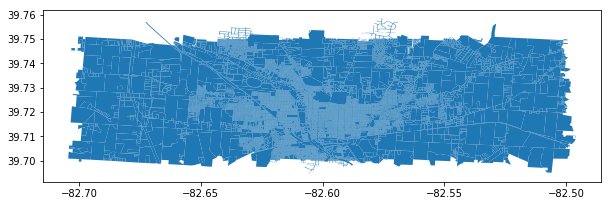

In [94]:
# lancaster
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (10, 10)
fairfield = fairfield.to_crs({'init': 'epsg:4326'})
fairfield[(fairfield.geometry.centroid.x >= -82.7) &
          (fairfield.geometry.centroid.x <= -82.5) &
          (fairfield.geometry.centroid.y >= 39.7) &
          (fairfield.geometry.centroid.y <= 39.75)].plot()


In [95]:
fairfield.CLASS.unique()

array(['A', 'R', 'C', 'E', 'I', '', 'U'], dtype=object)

In [96]:
fairfield_columns = ['SFLA', 'YRBLT', 'RMTOT', 'RMBED', 'FIXBATH', 
                     'FIXHALF', 'HEAT', 'PRICE', 'APRLAND',  'APRBLDG']

In [97]:
fairfield_subset = fairfield[fairfield.CLASS == 'R'][fairfield_columns].sample(frac=0.1).copy()

In [98]:
fairfield_subset.head()

,SFLA,YRBLT,RMTOT,RMBED,FIXBATH,FIXHALF,HEAT,PRICE,APRLAND,APRBLDG
57820,1540,1900,6,3,1,0,2,0.0,22760.0,56050.0
69764,2005,2000,7,4,2,1,3,174796.0,28650.0,129340.0
57977,936,1900,5,2,1,0,2,55000.0,28620.0,42110.0
24358,1260,1900,5,3,1,0,2,0.0,40300.0,34540.0
57862,0,0,0,0,0,0,,0.0,20990.0,105720.0


In [99]:
fairfield_subset.shape

(5680, 10)

In [100]:
fairfield_subset.columns

Index(['SFLA', 'YRBLT', 'RMTOT', 'RMBED', 'FIXBATH', 'FIXHALF', 'HEAT',
       'PRICE', 'APRLAND', 'APRBLDG'],
      dtype='object')

In [101]:
fairfield_subset['Bathrooms'] = fairfield_subset.FIXBATH + 0.5 * fairfield_subset.FIXHALF
fairfield_subset.drop(["FIXBATH", "FIXHALF"], axis=1, inplace=True)


In [102]:
fairfield_subset.HEAT.value_counts()

3    3560
     1011
2     735
4     312
1      62
Name: HEAT, dtype: int64

In [103]:
fairfield_subset['Heat'] = fairfield_subset.HEAT.astype(bool)

In [104]:
fairfield_subset.Heat.value_counts()

True     4669
False    1011
Name: Heat, dtype: int64

In [105]:
fairfield_subset.drop("HEAT", axis=1, inplace=True)

In [106]:
fairfield_subset.head()

,SFLA,YRBLT,RMTOT,RMBED,PRICE,APRLAND,APRBLDG,Bathrooms,Heat
57820,1540,1900,6,3,0.0,22760.0,56050.0,1.0,True
69764,2005,2000,7,4,174796.0,28650.0,129340.0,2.5,True
57977,936,1900,5,2,55000.0,28620.0,42110.0,1.0,True
24358,1260,1900,5,3,0.0,40300.0,34540.0,1.0,True
57862,0,0,0,0,0.0,20990.0,105720.0,0.0,False


In [107]:
fairfield_subset.rename(
    {'APRLAND': 'AppraisedLand',
     'APRBLDG': 'AppraisedBuilding',
     'PRICE': 'SalePrice',
     'SFLA': 'Area', 
     'RMTOT':'Rooms',
     'RMBED':'Bedrooms',
     'YRBLT': 'YearBuilt'
    },
    axis=1 ,
    inplace=True
)

In [108]:
fairfield_subset.head()

,Area,YearBuilt,Rooms,Bedrooms,SalePrice,AppraisedLand,AppraisedBuilding,Bathrooms,Heat
57820,1540,1900,6,3,0.0,22760.0,56050.0,1.0,True
69764,2005,2000,7,4,174796.0,28650.0,129340.0,2.5,True
57977,936,1900,5,2,55000.0,28620.0,42110.0,1.0,True
24358,1260,1900,5,3,0.0,40300.0,34540.0,1.0,True
57862,0,0,0,0,0.0,20990.0,105720.0,0.0,False


In [109]:
fairfield_subset["County"] = "Fairfield"

In [110]:
home_data = home_data.append(fairfield_subset, ignore_index=True)

In [111]:
home_data.shape

(46583, 12)

In [112]:
home_data.County.value_counts()

Franklin     35044
Licking       5859
Fairfield     5680
Name: County, dtype: int64

In [114]:
for column in home_data:
    if len(home_data[column].unique()) <= 25:
        display(home_data[column].value_counts())
       

True     39175
False     1728
Name: AirConditioning, dtype: int64

3.0     23239
4.0     11140
2.0      8421
0.0      1422
5.0       873
1.0       745
6.0       631
8.0        24
7.0        21
10.0        5
9.0         3
40.0        1
11.0        1
Name: Bedrooms, dtype: int64

Franklin     35044
Licking       5859
Fairfield     5680
Name: County, dtype: int64

0.0    24912
1.0    14182
2.0     1603
3.0      155
4.0       34
5.0        8
6.0        7
7.0        2
Name: Fireplaces, dtype: int64

True     45510
False     1073
Name: Heat, dtype: int64

6.0     12059
5.0     10274
7.0      8060
8.0      7139
4.0      4062
9.0      1563
0.0      1412
10.0      777
3.0       475
12.0      443
11.0      123
2.0        43
14.0       40
13.0       33
16.0        9
15.0        8
1.0         7
18.0        2
20.0        1
19.0        1
17.0        1
22.0        1
Name: Rooms, dtype: int64

0.9767726423802675

In [107]:
home_data.columns

Index(['AirConditioning', 'AppraisedBuilding', 'AppraisedLand', 'Area',
       'Bathrooms', 'Bedrooms', 'County', 'Fireplaces', 'Heat', 'Rooms',
       'SalePrice', 'YearBuilt'],
      dtype='object')

In [108]:
home_data.tail()

,AirConditioning,AppraisedBuilding,AppraisedLand,Area,Bathrooms,Bedrooms,County,Fireplaces,Heat,Rooms,SalePrice,YearBuilt
46578,NaN,59380.0,22390.0,992,1.0,3.0,Fairfield,NaN,True,5.0,0.0,1957.0
46579,NaN,78990.0,40000.0,1308,1.5,3.0,Fairfield,NaN,True,5.0,67500.0,1963.0
46580,NaN,64710.0,17460.0,1300,1.0,2.0,Fairfield,NaN,True,8.0,0.0,1900.0
46581,NaN,128080.0,38440.0,1662,2.0,3.0,Fairfield,NaN,True,6.0,0.0,1978.0
46582,NaN,141540.0,33560.0,1937,2.5,3.0,Fairfield,NaN,True,7.0,200000.0,2007.0


In [117]:
len(home_data.drop_duplicates())/len(home_data)

0.9767726423802675

In [119]:
home_data.drop_duplicates(inplace=True)

In [121]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/output.sqlite')
home_data.to_sql("home_data", con=engine, if_exists='replace')

In [122]:
# join dataframes
epa_data = pd.read_csv("./data/02-vehicles.csv")

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (71,73,74,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [126]:
from IPython.display import HTML
HTML(filename="./data/02-vehicles-description.html")

In [124]:
epa_data.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb
0,15.695714,0.0,0.0,0.0,19,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,423.190476,21,0.0,0,0.0,0.0,0.0,0.0,4.0,2.0,Rear-Wheel Drive,9011,(FFS),-1,1850,0,Regular,Regular Gasoline,-1,-1,25,0.0,0,0.0,0.0,0.0,0.0,0,0,1,0,0,Alfa Romeo,Spider Veloce 2000,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,23.3333,0.0,35.0000,0.0,Two Seaters,1985,-2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
1,29.964545,0.0,0.0,0.0,9,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,12.0,4.9,Rear-Wheel Drive,22020,(GUZZLER),-1,3550,0,Regular,Regular Gasoline,-1,-1,14,0.0,0,0.0,0.0,0.0,0.0,0,0,10,0,0,Ferrari,Testarossa,N,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,11.0000,0.0,19.0000,0.0,Two Seaters,1985,-10500,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
2,12.207778,0.0,0.0,0.0,23,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,329.148148,27,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,Front-Wheel Drive,2100,(FFS),-1,1450,0,Regular,Regular Gasoline,-1,-1,33,0.0,0,0.0,0.0,0.0,0.0,19,77,100,0,0,Dodge,Charger,Y,False,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,29.0000,0.0,47.0000,0.0,Subcompact Cars,1985,0,NaN,SIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
3,29.964545,0.0,0.0,0.0,10,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,807.909091,11,0.0,0,0.0,0.0,0.0,0.0,8.0,5.2,Rear-Wheel Drive,2850,NaN,-1,3550,0,Regular,Regular Gasoline,-1,-1,12,0.0,0,0.0,0.0,0.0,0.0,0,0,1000,0,0,Dodge,B150/B250 Wagon 2WD,N,False,0,0,0,0.0,0.0,0.0,0.0,Automatic 3-spd,12.2222,0.0,16.6667,0.0,Vans,1985,-10500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0
4,17.347895,0.0,0.0,0.0,17,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,467.736842,19,0.0,0,0.0,0.0,0.0,0.0,4.0,2.2,4-Wheel or All-Wheel Drive,66031,"(FFS,TRBO)",-1,2400,0,Premium,Premium Gasoline,-1,-1,23,0.0,0,0.0,0.0,0.0,0.0,0,0,10000,0,14,Subaru,Legacy AWD Turbo,N,False,0,90,0,0.0,0.0,0.0,0.0,Manual 5-spd,21.0000,0.0,32.0000,0.0,Compact Cars,1993,-4750,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0


In [167]:
sales = pd.read_csv("./data/02-vehicle-sales-norway.csv", encoding="ISO-8859-1")

In [168]:
sales.head()

,Year,Month,Make,Model,Quantity,Pct
0,2007,1,Volkswagen,Volkswagen Passat,1267,10.0
1,2007,1,Toyota,Toyota Rav4,819,6.5
2,2007,1,Toyota,Toyota Avensis,787,6.2
3,2007,1,Volkswagen,Volkswagen Golf,720,5.7
4,2007,1,Toyota,Toyota Corolla,691,5.4


In [169]:
sales.rename({"Model": "MakeModel"}, axis=1, inplace=True)

In [170]:
# could iterate, should use apply - faster for non-python
def remove_make(row):
    make = row['Make']
    make_model = row['MakeModel']
    return make_model.replace(make, "").strip()
    
sales["Model"] = sales.apply(remove_make, axis=1)

In [171]:
sales.head()

,Year,Month,Make,MakeModel,Quantity,Pct,Model
0,2007,1,Volkswagen,Volkswagen Passat,1267,10.0,Passat
1,2007,1,Toyota,Toyota Rav4,819,6.5,Rav4
2,2007,1,Toyota,Toyota Avensis,787,6.2,Avensis
3,2007,1,Volkswagen,Volkswagen Golf,720,5.7,Golf
4,2007,1,Toyota,Toyota Corolla,691,5.4,Corolla


In [172]:
sales.rename({col: col.lower() for col in sales.columns},
             axis=1, inplace=True)

In [173]:
epa_data.merge(sales, on=["year", "make", "model"])

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb,month,makemodel,quantity,pct


In [174]:
def strip_lower(x):
    return x.strip().lower()

In [175]:
epa_models = set(strip_lower(model) for model in epa_data.model)
sales_models = set(strip_lower(model) for model in sales.model)
epa_models.intersection(sales_models)

{'308',
 '6',
 '9-3',
 'a3',
 'a4',
 'a6',
 'c-hr',
 'corolla',
 'fiesta',
 'focus',
 'glc',
 'golf',
 'i30',
 'impreza',
 'leaf',
 'model s',
 'niro',
 'passat',
 'prius',
 'q3',
 'rav4',
 'soul',
 'swift',
 'sx4',
 'tiguan',
 'v40',
 'v90',
 'x3',
 'x5',
 'yaris'}

In [176]:
epa_makes = set(strip_lower(make) for make in epa_data.make)
sales_makes = set(strip_lower(make) for make in sales.make)
epa_makes.intersection(sales_makes)

{'audi',
 'bmw',
 'ford',
 'honda',
 'hyundai',
 'kia',
 'mazda',
 'mercedes-benz',
 'mitsubishi',
 'nissan',
 'peugeot',
 'renault',
 'saab',
 'subaru',
 'suzuki',
 'tesla',
 'toyota',
 'volkswagen',
 'volvo'}

In [177]:
set(epa_data.year).intersection(set(sales.year))

{2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}

In [178]:
epa_data.make = epa_data.make.apply(strip_lower)
epa_data.model = epa_data.model.apply(strip_lower)

In [179]:
sales.make = sales.make.apply(strip_lower)
sales.model = sales.model.apply(strip_lower)

In [180]:
epa_sales = epa_data.merge(sales, on=["year", "make", "model"])

In [181]:
epa_sales.head()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,drive,engId,eng_dscr,feScore,fuelCost08,fuelCostA08,fuelType,fuelType1,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,make,model,mpgData,phevBlended,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,trany,UCity,UCityA,UHighway,UHighwayA,VClass,year,youSaveSpend,guzzler,trans_dscr,tCharger,sCharger,atvType,fuelType2,rangeA,evMotor,mfrCode,c240Dscr,charge240b,c240bDscr,createdOn,modifiedOn,startStop,phevCity,phevHwy,phevComb,month,makemodel,quantity,pct
0,10.632581,0.0,0.0,0.0,29,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,286.677419,31,0.0,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,0,NaN,-1,1250,0,Regular,Regular Gasoline,-1,-1,35,0.0,0,0.0,0.0,0.0,0.0,13,85,22749,0,14,toyota,yaris,Y,False,0,87,0,0.0,0.0,0.0,0.0,Automatic 4-spd,37.6644,0.0,49.649,0.0,Subcompact Cars,2007,1000,NaN,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0,1,Toyota Yaris,402,3.2
1,10.632581,0.0,0.0,0.0,29,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,286.677419,31,0.0,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,0,NaN,-1,1250,0,Regular,Regular Gasoline,-1,-1,35,0.0,0,0.0,0.0,0.0,0.0,13,85,22749,0,14,toyota,yaris,Y,False,0,87,0,0.0,0.0,0.0,0.0,Automatic 4-spd,37.6644,0.0,49.649,0.0,Subcompact Cars,2007,1000,NaN,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0,2,Toyota Yaris,353,3.6
2,10.632581,0.0,0.0,0.0,29,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,286.677419,31,0.0,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,0,NaN,-1,1250,0,Regular,Regular Gasoline,-1,-1,35,0.0,0,0.0,0.0,0.0,0.0,13,85,22749,0,14,toyota,yaris,Y,False,0,87,0,0.0,0.0,0.0,0.0,Automatic 4-spd,37.6644,0.0,49.649,0.0,Subcompact Cars,2007,1000,NaN,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0,3,Toyota Yaris,267,2.4
3,10.632581,0.0,0.0,0.0,29,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,286.677419,31,0.0,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,0,NaN,-1,1250,0,Regular,Regular Gasoline,-1,-1,35,0.0,0,0.0,0.0,0.0,0.0,13,85,22749,0,14,toyota,yaris,Y,False,0,87,0,0.0,0.0,0.0,0.0,Automatic 4-spd,37.6644,0.0,49.649,0.0,Subcompact Cars,2007,1000,NaN,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0,4,Toyota Yaris,198,2.2
4,10.632581,0.0,0.0,0.0,29,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,286.677419,31,0.0,0,0.0,0.0,0.0,0.0,4.0,1.5,Front-Wheel Drive,0,NaN,-1,1250,0,Regular,Regular Gasoline,-1,-1,35,0.0,0,0.0,0.0,0.0,0.0,13,85,22749,0,14,toyota,yaris,Y,False,0,87,0,0.0,0.0,0.0,0.0,Automatic 4-spd,37.6644,0.0,49.649,0.0,Subcompact Cars,2007,1000,NaN,CLKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Tue Jan 01 00:00:00 EST 2013,Tue Jan 01 00:00:00 EST 2013,NaN,0,0,0,5,Toyota Yaris,270,2.2


In [182]:
epa_sales.describe()

,barrels08,barrelsA08,charge120,charge240,city08,city08U,cityA08,cityA08U,cityCD,cityE,cityUF,co2,co2A,co2TailpipeAGpm,co2TailpipeGpm,comb08,comb08U,combA08,combA08U,combE,combinedCD,combinedUF,cylinders,displ,engId,feScore,fuelCost08,fuelCostA08,ghgScore,ghgScoreA,highway08,highway08U,highwayA08,highwayA08U,highwayCD,highwayE,highwayUF,hlv,hpv,id,lv2,lv4,pv2,pv4,range,rangeCity,rangeCityA,rangeHwy,rangeHwyA,UCity,UCityA,UHighway,UHighwayA,year,youSaveSpend,charge240b,phevCity,phevHwy,phevComb,month,quantity,pct
count,1562.000000,1562.0,1562.0,1562.000000,1562.000000,1562.000000,1562.0,1562.0,1562.0,1562.000000,1562.0,1562.000000,1562.0,1562.0,1562.000000,1562.000000,1562.000000,1562.0,1562.0,1562.000000,1562.0,1562.0,1512.000000,1512.000000,1562.000000,1562.000000,1562.000000,1562.0,1562.000000,1562.0,1562.000000,1562.000000,1562.0,1562.0,1562.0,1562.000000,1562.0,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.0,1562.000000,1562.0,1562.000000,1562.0,1562.000000,1562.0,1562.000000,1562.000000,1562.000000,1562.0,1562.0,1562.0,1562.000000,1562.000000,1562.000000
mean,12.112483,0.0,0.0,0.238796,28.013444,19.313297,0.0,0.0,0.0,0.895684,0.0,151.313700,-1.0,0.0,325.575910,30.473111,20.888515,0.0,0.0,0.983008,0.0,0.0,4.294974,2.104894,65.350192,2.709347,1546.318822,0.0,2.631242,-1.0,34.879001,23.755406,0.0,0.0,0.0,1.091800,0.0,7.290013,40.483355,30406.505122,0.483995,8.281690,2.625480,53.166453,2.542894,2.710615,0.0,2.218945,0.0,36.521442,0.0,49.808192,0.0,2011.604994,-481.594110,0.107554,0.0,0.0,0.0,6.515365,359.620999,3.160930
std,2.924709,0.0,0.0,1.317095,18.153533,21.255202,0.0,0.0,0.0,4.945872,0.0,164.013207,0.0,0.0,79.673527,15.614908,20.341125,0.0,0.0,5.419013,0.0,0.0,0.619794,0.516443,154.703646,4.214617,383.981246,0.0,4.117399,0.0,12.714127,20.418295,0.0,0.0,0.0,6.013691,0.0,8.439392,45.203774,4564.910212,2.856609,7.474152,15.252517,47.044629,14.034588,15.128249,0.0,12.367836,0.0,26.777019,0.0,18.846797,0.0,2.935052,1919.906229,0.704125,0.0,0.0,0.0,3.467995,279.456021,2.229873
min,0.174000,0.0,0.0,0.000000,17.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1.000000,-1.0,0.0,0.000000,20.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,4.000000,1.500000,0.000000,-1.000000,550.000000,0.0,-1.000000,-1.0,24.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,22749.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,21.167500,0.0,34.100000,0.0,2007.000000,-4250.000000,0.000000,0.0,0.0,0.0,1.000000,13.000000,0.100000
25%,11.240735,0.0,0.0,0.000000,21.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,-1.000000,-1.0,0.0,292.000000,24.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,4.000000,1.800000,0.000000,-1.000000,1350.000000,0.0,-1.000000,-1.0,29.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,25343.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,26.025200,0.0,40.400300,0.0,2009.000000,-2250.000000,0.000000,0.0,0.0,0.0,4.000000,188.000000,1.700000
50%,12.677308,0.0,0.0,0.000000,24.000000,21.990400,0.0,0.0,0.0,0.000000,0.0,0.000000,-1.0,0.0,334.000000,26.000000,25.281500,0.0,0.0,0.000000,0.0,0.0,4.000000,2.000000,34.000000,-1.000000,1500.000000,0.0,-1.000000,-1.0,33.000000,30.026000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,31602.000000,0.000000,13.000000,0.000000,87.000000,0.000000,0.000000,0.0,0.000000,0.0,29.605500,0.0,44.508800,0.0,2012.000000,-250.000000,0.000000,0.0,0.0,0.0,7.000000,273.000000,2.400000
75%,13.733750,0.0,0.0,0.000000,29.000000,28.500000,0.0,0.0,0.0,0.000000,0.0,317.000000,-1.0,0.0,370.291667,32.000000,31.849800,0.0,0.0,0.000000,0.0,0.0,4.000000,2.300000,76.000000,7.000000,1900.000000,0.0,7.000000,-1.0,36.000000,35.058600,0.0,0.0,0.0,0.000000,0.0,15.000000,93.000000,33948.000000,0.000000,15.000000,0.000000,96.000000,0.000000,0.000000,0.0,0.000000,0.0,38.700000,0.0,52.834400,0.0,2014.000000,500.000000,0.000000,0.0,0.0,0.0,10.000000,414.000000,3.900000
max,16.480500,0.0,0.0,8.000000,129.000000,128.92170

In [183]:
epa_sales.to_sql("epa_sales", con=engine, if_exists='replace')